# Anomalies Extraction Functions

In [1]:
from scipy.signal import welch
from scipy.stats import zscore
import numpy as np

def eeg_band_anomaly_detector(
    eeg_df,
    sampling_rate=128,
    window_sec=2,
    alpha_thresh=0.2,
    beta_thresh=0.2,
):
    """
    Robust EEG anomaly detector for PhysioGPT.
    -----------------------------------------
    Handles inconsistent column types, tuple keys, and non-flat DataFrames.
    """

    # --- 1️⃣ Normalize columns ---
    if isinstance(eeg_df.columns[0], tuple):
        eeg_df.columns = ['_'.join(map(str, col)).strip() for col in eeg_df.columns]
    eeg_df.columns = eeg_df.columns.str.strip()

    if 'Timestamp' not in eeg_df.columns:
        raise ValueError("Expected 'Timestamp' column in EEG data.")

    # Remove non-numeric or unwanted columns like 'Condition'
    eeg_channels = [
        c for c in eeg_df.select_dtypes(include=['number']).columns
        if c not in ['Timestamp', 'Condition']
    ]

    window_size = sampling_rate * window_sec
    total_samples = len(eeg_df)
    num_windows = total_samples // window_size

    band_powers = {ch: {'theta': [], 'alpha': [], 'beta': []} for ch in eeg_channels}
    window_times = []

    # --- 2️⃣ Sliding window processing ---
    for w in range(num_windows):
        start, end = w * window_size, (w + 1) * window_size
        segment = eeg_df.iloc[start:end]
        if len(segment) < window_size:
            continue

        mean_time = eeg_df['Timestamp'].iloc[start:end].mean()
        window_times.append(mean_time)

        for ch in eeg_channels:
            try:
                # ✅ force numeric 1D array
                data = np.asarray(segment[ch], dtype=float)
                if np.all(np.isnan(data)):
                    continue

                freqs, psd = welch(data, fs=sampling_rate, nperseg=window_size)
                theta = np.trapezoid(psd[(freqs >= 4) & (freqs < 8)])
                alpha = np.trapezoid(psd[(freqs >= 8) & (freqs < 12)])
                beta = np.trapezoid(psd[(freqs >= 13) & (freqs < 30)])

                band_powers[ch]['theta'].append(theta)
                band_powers[ch]['alpha'].append(alpha)
                band_powers[ch]['beta'].append(beta)

            except Exception as e:
                print(f"[EEG] Skipping {ch} at window {w}: {e}")
                continue

    # --- 3️⃣ Local ratio-based anomaly detection ---
    anomalies = []
    for ch in eeg_channels:
        for i, time in enumerate(window_times):
            theta = band_powers[ch]['theta'][i]
            alpha = band_powers[ch]['alpha'][i]
            beta = band_powers[ch]['beta'][i]
            total = theta + alpha + beta
            if total == 0:
                continue

            alpha_ratio = alpha / total
            beta_ratio = beta / total

            if alpha_ratio < alpha_thresh:
                anomalies.append(f"Low alpha ratio in {ch} at {time:.2f}s (ratio = {alpha_ratio:.2f})")
            if beta_ratio < beta_thresh:
                anomalies.append(f"Low beta ratio in {ch} at {time:.2f}s (ratio = {beta_ratio:.2f})")

    # --- 4️⃣ Global z-score detection ---
    for band in ['alpha', 'beta']:
        band_means = [np.mean(band_powers[ch][band]) for ch in eeg_channels if band_powers[ch][band]]
        if len(band_means) == 0:
            continue
        band_zscores = zscore(band_means)
        for ch, z in zip(eeg_channels, band_zscores):
            if z < -1.5:
                label = "Suppressed Alpha" if band == "alpha" else "Suppressed Beta"
                anomalies.append(f"{label} globally in {ch} (z = {z:.2f})")

    return anomalies if anomalies else ["No significant EEG band anomalies detected."]

In [2]:
import numpy as np
import pandas as pd

def detect_hrv_suppression(
    hrv_df: pd.DataFrame,
    suppression_threshold: float = 30.0,
    verbose: bool = False
):
    if 'Timestamp' not in hrv_df.columns:
        raise ValueError("Expected 'Timestamp' column in HRV data.")
    if 'HR [bpm]' not in hrv_df.columns:
        raise ValueError("Expected 'HR [bpm]' column in HRV data.")

    rr_intervals = 60000 / hrv_df['HR [bpm]'].replace(0, np.nan).dropna()
    sdnn = np.std(rr_intervals)

    status = "Suppressed" if sdnn < suppression_threshold else "Normal"
    summary_text = (
        f"HRV suppression detected (SDNN = {sdnn:.2f} ms, below {suppression_threshold} ms)."
        if status == "Suppressed"
        else f"No significant HRV suppression detected (SDNN = {sdnn:.2f} ms)."
    )

    if verbose:
        print(f"[HRV] SDNN = {sdnn:.2f} ms → {status}")

    return {"SDNN_ms": sdnn, "Status": status, "Summary": summary_text}

In [3]:
def generate_full_cognitive_summary(eeg_df, hrv_df):
    eeg_anomalies = eeg_band_anomaly_detector(eeg_df)
    hrv_result = detect_hrv_suppression(hrv_df)
    return {
        "EEG Anomalies": eeg_anomalies,
        "HRV Analysis": hrv_result
    }

# LLM Setup

In [4]:
from openai import OpenAI
from google.colab import userdata
import json, time

# Initialize client once
client = OpenAI(api_key=userdata.get("OPENAI_API_KEY"))

def call_llm_api(prompt, model="gpt-4o", system_role=None, temperature=0.0, max_tokens=700, retries=3, verbose=False):
    """
    Wrapper for PhysioGPT reasoning calls.

    Parameters
    ----------
    prompt : str
        Full text prompt (ontology + subject summary + task).
    model : str
        Model identifier (default: gpt-4o).
    system_role : str or None
        Custom system prompt. Defaults to domain-specific role if None.
    temperature : float
        Sampling temperature (0 for deterministic behavior).
    max_tokens : int
        Maximum tokens for the LLM response.
    retries : int
        Number of retry attempts on API failure.
    verbose : bool
        Print diagnostic info.

    Returns
    -------
    dict
        {
          'model': str,
          'response_text': str,
          'timestamp': str
        }
    """
    if system_role is None:
        system_role = (
            "You are PhysioGPT, an ontology-guided clinical reasoning assistant. "
            "Follow the ontology strictly, be concise, and output in the required format."
        )

    for attempt in range(retries):
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": system_role},
                    {"role": "user", "content": prompt}
                ],
                temperature=temperature,
                max_tokens=max_tokens,
            )
            result = response.choices[0].message.content.strip()
            if verbose:
                print(f"[LLM] Completed on attempt {attempt+1}, tokens used ≈ {response.usage.total_tokens}")
            return {
                "model": model,
                "response_text": result,
                "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
            }

        except Exception as e:
            print(f"[LLM] Error on attempt {attempt+1}: {e}")
            time.sleep(2)
    raise RuntimeError("LLM API failed after multiple retries.")

In [5]:
import re

def parse_llm_output_flexible(text: str) -> str:
    """
    Parses the PhysioGPT output and returns a normalized class label.

    Expected patterns:
        "Conclusion: Yes"    → 'MCI'
        "Conclusion: No"     → 'Healthy'
        "Needs clinical review" or uncertain wording → 'Review'

    Parameters
    ----------
    text : str
        Raw LLM output string.

    Returns
    -------
    str
        One of {'MCI', 'Healthy', 'Review'}
    """
    if not text:
        return "Review"  # default if empty or None

    t = text.lower().strip()

    # Normalize any punctuation or line breaks
    t = re.sub(r'\s+', ' ', t)

    # Explicit patterns first
    if "needs clinical review" in t or "needs review" in t or "uncertain" in t:
        return "Review"

    # Broader patterns
    if re.search(r"conclusion[:\-]?\s*yes", t) or "mci" in t:
        return "MCI"

    if re.search(r"conclusion[:\-]?\s*no", t) or "healthy" in t:
        return "Healthy"

    # Fallback
    return "Review"

In [6]:
import re
from typing import List

def build_physio_prompt_cogaut(eeg_anomalies: List[str], hrv_summary_text: str, subject_id: str = "Unknown"):
    """
    Builds a PhysioGPT reasoning prompt for the cognitive–autonomic (EEG + HRV) domain.

    Parameters
    ----------
    eeg_anomalies : list of str
        Textual anomaly summaries from eeg_band_anomaly_detector.
    hrv_summary_text : str
        Output summary string from detect_hrv_suppression.
    subject_id : str
        Optional subject identifier for traceability.

    Returns
    -------
    str
        Complete text prompt for PhysioGPT.
    """

    ontology_reference = """
Ontology Reference (Cognitive–Autonomic Domain)
------------------------------------------------
EEG:
- Persistent theta elevation and alpha suppression → cognitive decline (MCI).
- Beta suppression → cognitive slowing or attentional deficit.
HRV:
- SDNN < 30 ms → reduced autonomic flexibility linked to MCI.
- SDNN ≥ 50 ms → healthy autonomic regulation.

Diagnostic Rules:
- Classify as **MCI** if at least two abnormal features co-occur
  (alpha↓, beta↓, HRV↓, theta↑), or one strong EEG feature + HRV suppression.
- Classify as **Healthy** if alpha/beta activity is within normal range
  and HRV is ≥ 50 ms, with no strong EEG suppression detected.
- If findings are partially abnormal but not conclusive, return **Needs clinical review**.
"""


    task_instruction = """
Task:
Analyze the EEG and HRV summaries using the ontology above and respond *strictly* in the following format:

Conclusion: [MCI / Healthy / Needs clinical review]
Explanation: [Brief justification referencing the findings]

Be decisive — do not choose 'Needs clinical review' unless evidence is explicitly mixed or borderline.
"""

    # Filter to relevant features and handle edge cases
    def extract_ratio(s):
        try:
            return float(re.search(r"ratio\s*=\s*([\d.]+)", s).group(1))
        except Exception:
            return 1.0  # fallback if no numeric ratio found

    filtered = [a for a in eeg_anomalies if any(k in a.lower() for k in ["alpha", "beta", "theta"])]
    eeg_summary = sorted(filtered, key=extract_ratio)[:7]
    eeg_text = "\n".join(eeg_summary) if eeg_summary else "No significant EEG anomalies detected."

    return (
        f"Subject ID: {subject_id}\n\n"
        f"{ontology_reference}\n\n"
        f"EEG Summary:\n{eeg_text}\n\n"
        f"HRV Summary:\n{hrv_summary_text}\n\n"
        f"{task_instruction}"
    )

# Classification

In [7]:
import os
import pandas as pd
from tqdm import tqdm

# Paths
EEG_DIR = "/content/drive/MyDrive/2025/NeuroSyncAI/mci_dataset/EEG"
HRV_DIR = "/content/drive/MyDrive/2025/NeuroSyncAI/mci_dataset/HRV"

# True labels
TRUE_LABELS = {
    "subject_0_394": 0,
    "subject_0_399": 0,
    "subject_0_462": 0,
    "subject_0_463": 0,
    "subject_0_468": 0,
    "subject_0_475": 0,
    "subject_0_476": 0,
    "subject_1_397": 1,
    "subject_1_455": 1,
    "subject_1_456": 1,
    "subject_1_457": 1,
    "subject_1_459": 1,
    "subject_1_461": 1,
    "subject_1_464": 1,
    "subject_1_467": 1
}

In [8]:
from tqdm import tqdm
import pandas as pd
import os, json, time

all_llm_results = []

for subject_id, condition in tqdm(TRUE_LABELS.items(), desc="Running PhysioGPT"):
    eeg_file = os.path.join(EEG_DIR, f"{subject_id}_with_timestamp.csv")
    hrv_file = os.path.join(HRV_DIR, f"{subject_id}_HRV_with_timestamp.csv")

    try:
        # -----------------------------
        # Load data
        # -----------------------------
        eeg_df = pd.read_csv(eeg_file)
        hrv_df = pd.read_csv(hrv_file)

        # -----------------------------
        # 1️⃣ Generate summaries
        # -----------------------------
        eeg_anomalies = eeg_band_anomaly_detector(eeg_df)
        hrv_summary = detect_hrv_suppression(hrv_df)
        hrv_summary_text = hrv_summary["Summary"]  # ✅ extract string

        # -----------------------------
        # 2️⃣ Build PhysioGPT prompt
        # -----------------------------
        prompt = build_physio_prompt_cogaut(
            eeg_anomalies,
            hrv_summary_text,
            subject_id=subject_id
        )

        # -----------------------------
        # 3️⃣ Query the model
        # -----------------------------
        llm_response_obj = call_llm_api(prompt)
        llm_raw_text = llm_response_obj["response_text"]

        # -----------------------------
        # 4️⃣ Parse the structured output
        # -----------------------------
        parsed_decision = parse_llm_output_flexible(llm_raw_text)

        # -----------------------------
        # 5️⃣ Store the result
        # -----------------------------
        all_llm_results.append({
            "Subject": subject_id,
            "True Label": "MCI" if condition == 1 else "Healthy",
            "LLM Decision": parsed_decision,
            "LLM Output": llm_raw_text,
            "Model": llm_response_obj["model"],
            "Timestamp": llm_response_obj["timestamp"]
        })

        time.sleep(0.5)  # small delay to avoid hitting rate limits

    except Exception as e:
        print(f"[Error] {subject_id}: {e}")
        all_llm_results.append({
            "Subject": subject_id,
            "True Label": "MCI" if condition == 1 else "Healthy",
            "LLM Decision": "error",
            "LLM Output": f"Exception: {e}",
            "Model": None,
            "Timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
        })

Running PhysioGPT: 100%|██████████| 15/15 [01:56<00:00,  7.76s/it]


In [9]:
# Save results + accuracy
results_df = pd.DataFrame(all_llm_results)
results_df.to_csv("/content/drive/MyDrive/2025/NeuroSyncAI/mci_dataset/PhysioGPT_llm_subject_predictions_latest_152.csv", index=False)
results_df.to_csv("llm_subject_predictions_latest_152.csv", index=False)

In [10]:
results_df

,Subject,True Label,LLM Decision,LLM Output,Model,Timestamp
0,subject_0_394,Healthy,Healthy,Conclusion: Healthy \nExplanation: The EEG sh...,gpt-4o,2025-11-09 22:49:13
1,subject_0_399,Healthy,Healthy,Conclusion: Healthy \nExplanation: The EEG sh...,gpt-4o,2025-11-09 22:49:20
2,subject_0_462,Healthy,Healthy,Conclusion: Healthy \nExplanation: The EEG sh...,gpt-4o,2025-11-09 22:49:26
3,subject_0_463,Healthy,MCI,Conclusion: MCI \nExplanation: The EEG shows ...,gpt-4o,2025-11-09 22:49:36
4,subject_0_468,Healthy,Healthy,Conclusion: Healthy \nExplanation: The EEG sh...,gpt-4o,2025-11-09 22:49:42
5,subject_0_475,Healthy,Review,Conclusion: Needs clinical review \nExplanati...,gpt-4o,2025-11-09 22:49:49
6,subject_0_476,Healthy,Review,Conclusion: Needs clinical review \nExplanati...,gpt-4o,2025-11-09 22:49:54
7,subject_1_397,MCI,Review,Conclusion: Needs clinical review \nExplanati...,gpt-4o,2025-11-09 22:50:00
8,subject_1_455,MCI,MCI,Conclusion: MCI \nExplanation: The subject ex...,gpt-4o,2025-11-09 22:50:07
9,subject_1_456,MCI,MCI,Conclusion: MCI \nExplanation: The subject ex...,gpt-4o,2025-11-09 22:50:12


# Results

In [ ]:
def parse_llm_output_threeclass(text: str) -> str:
    t = text.lower()
    if "needs clinical review" in t or "uncertain" in t:
        return "Review"
    if "conclusion" in t and "yes" in t:
        return "MCI"
    if "conclusion" in t and "no" in t:
        return "Healthy"
    return "Review"

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(results_df["True Label"], results_df["LLM Decision"], labels=["Healthy","MCI"]))
print(confusion_matrix(results_df["True Label"], results_df["LLM Decision"], labels=["Healthy","MCI"]))

              precision    recall  f1-score   support

     Healthy       1.00      0.57      0.73         7
         MCI       0.88      0.88      0.88         8

   micro avg       0.92      0.73      0.81        15
   macro avg       0.94      0.72      0.80        15
weighted avg       0.93      0.73      0.81        15

[[4 1]
 [0 7]]


In [ ]:
# drop Review predictions
binary_df = results_df[results_df["LLM Decision"] != "Review"]
coverage = len(binary_df) / len(results_df)
accuracy = (binary_df["True Label"] == binary_df["LLM Decision"]).mean()
print(f"Coverage={coverage:.2f}, Accuracy={accuracy:.2f}")

Coverage=0.80, Accuracy=0.92


### Plots

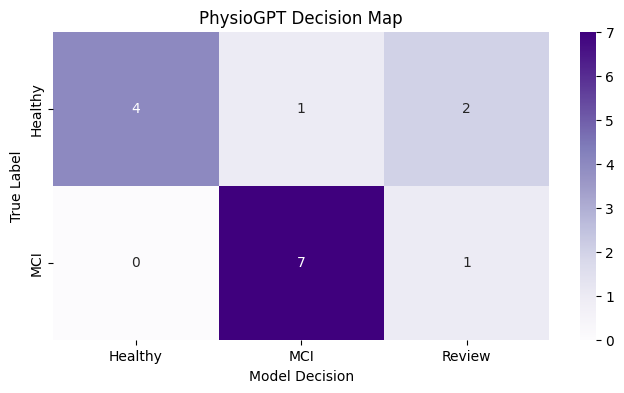

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by True Label × LLM Decision to get counts
summary = (
    results_df.groupby(["True Label", "LLM Decision"])
      .size()
      .reset_index(name="count")
)

# Use keyword arguments for pivot
pivot_df = summary.pivot(index="True Label", columns="LLM Decision", values="count").fillna(0)

plt.figure(figsize=(8,4))
sns.heatmap(pivot_df, annot=True, fmt=".0f", cmap="Purples")
plt.title("PhysioGPT Decision Map")
plt.xlabel("Model Decision")
plt.ylabel("True Label")
plt.show()

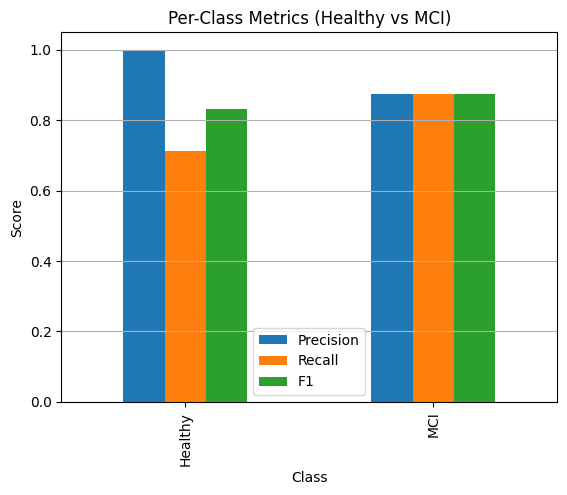

In [ ]:
metrics = pd.DataFrame({
    'Class': ['Healthy','MCI'],
    'Precision': [1.00, 0.875],
    'Recall': [0.714, 0.875],
    'F1': [0.833, 0.875]
}).set_index('Class')

metrics.plot(kind='bar')
plt.title("Per-Class Metrics (Healthy vs MCI)")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(axis='y')

# Ablation

In [11]:
import re, random, numpy as np

# --- Leakage neutralization ---
LEAK_WORDS = ["suppressed", "low", "below", "elevated", "strong", "widespread", "disorganization"]
LEAK_PATTERN = re.compile("|".join([re.escape(w) for w in LEAK_WORDS]), re.IGNORECASE)

# --- Discretization helper ---
def bin_value(x, edges=(0.0, 0.2, 0.4, 0.6, 1.0)):
    for i in range(len(edges) - 1):
        if edges[i] <= x < edges[i + 1]:
            return i
    return len(edges) - 2

# --- EEG cleaning ---
def sanitize_eeg_anomalies(anomalies):
    """
    Converts qualitative anomaly strings into normalized numeric bins.
    """
    clean = []
    for a in anomalies:
        ch_match = re.search(r"(EEG\.[A-Z0-9]+|[A-Z0-9]+)", a)
        ch = ch_match.group(0) if ch_match else "EEG.?"
        m = re.search(r"ratio\s*=\s*([\d\.]+)", a)
        if m:
            r = float(m.group(1))
            b = bin_value(r)
            if "alpha" in a.lower() or "beta" in a.lower():
                clean.append(f"{ch} alpha_beta_ratio_bin={b}")
            else:
                clean.append(f"{ch} band_bin={b}")
        else:
            a = LEAK_PATTERN.sub("X", a)
            clean.append(re.sub(r"\(.*?\)", "", a))
    return list(dict.fromkeys(clean))[:10]

# --- HRV cleaning ---
def sanitize_hrv_summary(hrv_summary_text):
    m = re.search(r"SDNN\s*=\s*([\d\.]+)", hrv_summary_text)
    if m:
        return f"SDNN_ms={float(m.group(1)):.2f}"
    nums = re.findall(r"[\d\.]+", hrv_summary_text)
    return f"SDNN_ms={nums[0]}" if nums else "SDNN_ms=?"

# --- Random shuffling + synonym injection ---
SYNONYMS = {
    "Summary": ["Profile", "Snapshot", "Overview"],
    "Conclusion": ["Decision", "Final verdict", "Outcome"],
}
def synonymize(s): return s.replace("Summary", random.choice(SYNONYMS["Summary"]))
def shuffle_lines(block): return "\n".join(random.sample(block.splitlines(), len(block.splitlines())))

# --- PROMPT VARIANTS ---

def prompt_numeric_only(eeg_anomalies, hrv_text, subject_id="id"):
    eeg_clean = sanitize_eeg_anomalies(eeg_anomalies)
    hrv_clean = sanitize_hrv_summary(hrv_text)
    ontology = """
Ontology (Cognitive–Autonomic):
- Reduced alpha/beta and lower HRV may indicate impairment.
- Decide from numeric summaries only; do not assume thresholds.
"""
    task = """
Task:
Return exactly one: Healthy / MCI / Needs clinical review
Explain briefly using only numbers/bins.
"""
    return f"Subject: {subject_id}\n{ontology}\nEEG Numeric: {', '.join(eeg_clean)}\nHRV Numeric: {hrv_clean}\n{task}"

def prompt_randomized(eeg_anomalies, hrv_text, subject_id="id"):
    base = prompt_numeric_only(eeg_anomalies, hrv_text, subject_id)
    return synonymize(shuffle_lines(base))

def prompt_threshold_jittered(eeg_anomalies, hrv_text, subject_id="id", jitter_ms=5):
    jitter = 30 + np.random.choice([-jitter_ms, +jitter_ms])
    eeg_clean = sanitize_eeg_anomalies(eeg_anomalies)
    hrv_clean = sanitize_hrv_summary(hrv_text)
    ontology = f"""
Ontology:
- Lower HRV is associated with autonomic rigidity (typical SDNN ~ 40–60 ms).
- Values near ~{jitter} ms may be concerning depending on EEG context.
"""
    task = "Return: Healthy / MCI / Needs clinical review. Base decision on convergence, not any single cutoff."
    return f"Subject: {subject_id}\n{ontology}\nEEG: {', '.join(eeg_clean)}\nHRV: {hrv_clean}\n{task}"

def prompt_quantized(eeg_anomalies, hrv_text, subject_id="id"):
    eeg_clean = [re.sub(r"ratio\s*=\s*[\d\.]+", "ratio_bin", a) for a in sanitize_eeg_anomalies(eeg_anomalies)]
    hrv_clean = re.sub(r"[\d\.]+", "BIN", sanitize_hrv_summary(hrv_text))
    ontology = """
Ontology (Quantized Cognitive–Autonomic):
- All values are discretized into coarse bins (low/med/high).
- Use relative comparison logic, not absolute numbers.
"""
    task = """
Task:
Return one: Healthy / MCI / Needs clinical review
Focus on relational cues among bins.
"""
    return f"Subject: {subject_id}\n{ontology}\nEEG: {', '.join(eeg_clean)}\nHRV: {hrv_clean}\n{task}"

In [12]:
import os, numpy as np, pandas as pd
from tqdm import tqdm
from sklearn.metrics import classification_report, matthews_corrcoef, balanced_accuracy_score

# =====================================================
# Metric utilities (auto-detect column names)
# =====================================================

def metrics_from_df(df):
    true_cols = [c for c in df.columns if "true" in c.lower()]
    pred_cols = [c for c in df.columns if any(k in c.lower() for k in ["pred", "decision"])]

    if not true_cols or not pred_cols:
        raise ValueError(f"Could not infer label columns from {df.columns}")

    y_true = df[true_cols[0]].astype(str).values
    y_pred = df[pred_cols[0]].astype(str).values

    # Coverage = fraction not deferred for review
    covered_mask = y_pred != "Review"
    coverage = covered_mask.mean()
    acc_covered = (y_true[covered_mask] == y_pred[covered_mask]).mean() if coverage > 0 else np.nan

    # Balanced Acc, MCC, F1
    labels = sorted(list(set(y_true) | set(y_pred)))
    try:
        bal_acc = balanced_accuracy_score(y_true, y_pred)
    except Exception:
        bal_acc = np.nan
    try:
        mcc = matthews_corrcoef(y_true, y_pred)
    except Exception:
        mcc = np.nan

    rep = classification_report(y_true, y_pred, labels=labels, output_dict=True, zero_division=0)
    macro_f1 = rep.get("macro avg", {}).get("f1-score", np.nan)

    # ✅ Use normal keys (Python identifiers) and rename later for display
    return dict(
        coverage=coverage,
        acc_covered=acc_covered,
        bal_acc=bal_acc,
        mcc=mcc,
        macro_f1=macro_f1
    )


def summarize(results_dict):
    df = pd.DataFrame({name: metrics_from_df(df) for name, df in results_dict.items()}).T
    # Rename acc_covered column for readability
    return df.rename(columns={"acc_covered": "acc@covered"})


# =====================================================
# Prompt registry
# =====================================================

PROMPTS = {
    "NumericOnly": prompt_numeric_only,
    "Randomized": prompt_randomized,
    "ThresholdJittered": prompt_threshold_jittered,
    "Quantized": prompt_quantized,
}


# =====================================================
# Core evaluation loop
# =====================================================

def run_eeg_hrv_ablation(true_labels, temperature=0.3):
    """
    Executes all PhysioGPT EEG + HRV ablation variants.
    true_labels: dict {subject_id: 0/1}
    Returns (results_dict, summary_df)
    """
    results_all = {}

    for name, build_prompt_fn in PROMPTS.items():
        print(f"\n🔹 Running {name} variant...")
        rows = []

        for subject_id, cond in tqdm(true_labels.items(), desc=f"Variant {name}"):
            eeg_file = os.path.join(EEG_DIR, f"{subject_id}_with_timestamp.csv")
            hrv_file = os.path.join(HRV_DIR, f"{subject_id}_HRV_with_timestamp.csv")

            try:
                eeg_df = pd.read_csv(eeg_file)
                hrv_df = pd.read_csv(hrv_file)

                eeg_anoms = eeg_band_anomaly_detector(eeg_df)
                hrv_sum = detect_hrv_suppression(hrv_df)
                hrv_text = hrv_sum["Summary"] if isinstance(hrv_sum, dict) else str(hrv_sum)

                prompt = build_prompt_fn(eeg_anoms, hrv_text, subject_id)
                out = call_llm_api(prompt, temperature=temperature)
                yhat = parse_llm_output_flexible(out["response_text"])

                rows.append({
                    "Subject": subject_id,
                    "True Label": "MCI" if cond == 1 else "Healthy",
                    "LLM Decision": yhat,
                    "Explanation": out["response_text"],
                    "Model": out.get("model", "gpt-4o"),
                    "Timestamp": out.get("timestamp"),
                })

            except Exception as e:
                print(f"[Error] {subject_id}: {e}")
                rows.append({
                    "Subject": subject_id,
                    "True Label": "MCI" if cond == 1 else "Healthy",
                    "LLM Decision": "error",
                    "Explanation": str(e),
                    "Model": None,
                    "Timestamp": None,
                })

        results_all[name] = pd.DataFrame(rows)

    summary = summarize(results_all)
    return results_all, summary


# =====================================================
# Run and display summary
# =====================================================

all_results, summary_eeg_hrv = run_eeg_hrv_ablation(TRUE_LABELS, temperature=0.3)
display(summary_eeg_hrv)


🔹 Running NumericOnly variant...


Variant NumericOnly: 100%|██████████| 15/15 [01:00<00:00,  4.06s/it]



🔹 Running Randomized variant...


Variant Randomized: 100%|██████████| 15/15 [01:08<00:00,  4.58s/it]



🔹 Running ThresholdJittered variant...


Variant ThresholdJittered: 100%|██████████| 15/15 [01:12<00:00,  4.83s/it]



🔹 Running Quantized variant...


Variant Quantized: 100%|██████████| 15/15 [01:12<00:00,  4.82s/it]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


,coverage,acc@covered,bal_acc,mcc,macro_f1
NumericOnly,0.000000,NaN,0.000000,0.000000,0.000000
Randomized,0.066667,0.0,0.000000,-0.142857,0.000000
ThresholdJittered,0.333333,0.8,0.285714,0.236228,0.222222
Quantized,0.200000,1.0,0.214286,0.267261,0.200000


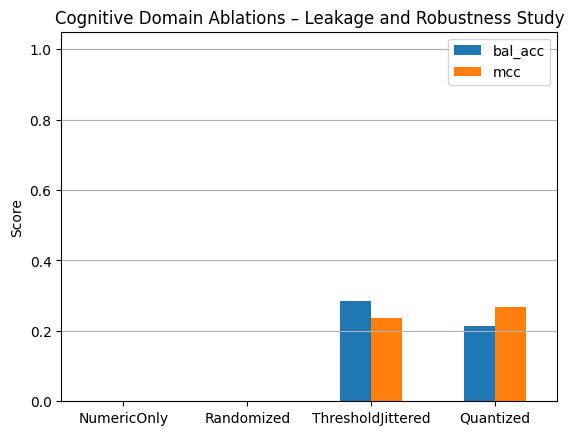

In [15]:
import matplotlib.pyplot as plt

summary_eeg_hrv[['bal_acc','mcc']].plot.bar(rot=0)
plt.title("Cognitive Domain Ablations – Leakage and Robustness Study")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(axis='y')

In [16]:
def count_outcomes(df):
    """Count correct, incorrect, and deferred cases for an ablation result DataFrame."""
    true_cols = [c for c in df.columns if "true" in c.lower()]
    pred_cols = [c for c in df.columns if any(k in c.lower() for k in ["pred", "decision"])]

    y_true = df[true_cols[0]].astype(str).values
    y_pred = df[pred_cols[0]].astype(str).values

    # --- Counts ---
    total = len(y_true)
    deferred = np.sum(y_pred == "Review")
    correct = np.sum((y_pred == y_true) & (y_pred != "Review"))
    incorrect = np.sum((y_pred != y_true) & (y_pred != "Review"))

    return {
        "Total": total,
        "Correct": correct,
        "Incorrect": incorrect,
        "Deferred": deferred,
        "Coverage": (total - deferred) / total,
        "Accuracy@Covered": correct / (total - deferred) if (total - deferred) > 0 else np.nan,
    }

def summarize_counts(results_dict):
    """Return a compact DataFrame of outcome counts per ablation."""
    return pd.DataFrame({name: count_outcomes(df) for name, df in results_dict.items()}).T


In [17]:
summary_counts = summarize_counts(all_results)

print("\n=== Cognitive PhysioGPT Outcome Counts ===")
display(summary_counts)


=== Cognitive PhysioGPT Outcome Counts ===


,Total,Correct,Incorrect,Deferred,Coverage,Accuracy@Covered
NumericOnly,15.0,0.0,0.0,15.0,0.000000,NaN
Randomized,15.0,0.0,1.0,14.0,0.066667,0.0
ThresholdJittered,15.0,4.0,1.0,10.0,0.333333,0.8
Quantized,15.0,3.0,0.0,12.0,0.200000,1.0


In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_physio_summary(summary_counts: pd.DataFrame, title="PhysioGPT Ablation", save_prefix=None):
    """
    Plot accuracy and outcome distribution from summary_counts DataFrame.

    Expected columns:
      ['Correct', 'Incorrect', 'Deferred', 'Accuracy@Covered']
    """
    # Reset index to access variant names (like 'Original', 'NumericOnly', etc.)
    df = summary_counts.reset_index().rename(columns={"index": "Variant"})

    # --- Plot 1: Accuracy @ Covered ---
    plt.figure(figsize=(7, 4))
    plt.bar(df["Variant"], df["Accuracy@Covered"], color="#2db483", alpha=0.9)
    plt.title(f"{title} – Accuracy @ Covered", fontsize=13, weight="bold")
    plt.ylabel("Accuracy", fontsize=12)
    plt.ylim(0, 1.05)
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.xticks(rotation=30, ha="right", fontsize=11)
    plt.tight_layout()
    if save_prefix:
        plt.savefig(f"{save_prefix}_accuracy.png", dpi=300, bbox_inches="tight")
    plt.show()

    # --- Plot 2: Stacked outcome proportions ---
    cols = ["Correct", "Incorrect", "Deferred"]
    totals = df[cols].sum(axis=1)
    proportions = df[cols].div(totals, axis=0)

    plt.figure(figsize=(7, 4))
    bottom = np.zeros(len(df))
    colors = ["#2db483", "#e57373", "#fbc02d"]
    for col, color in zip(cols, colors):
        plt.bar(df["Variant"], proportions[col], bottom=bottom, label=col, color=color, alpha=0.9)
        bottom += proportions[col].fillna(0).values

    plt.title(f"{title} – Outcome Distribution", fontsize=13, weight="bold")
    plt.ylabel("Proportion of Subjects", fontsize=12)
    plt.ylim(0, 1)
    plt.legend(
        frameon=True,
        facecolor="white",
        edgecolor="lightgray",
        loc="upper right",
        fontsize=10
    )

    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.xticks(rotation=30, ha="right", fontsize=11)
    plt.tight_layout()
    if save_prefix:
        plt.savefig(f"{save_prefix}_outcomes.png", dpi=300, bbox_inches="tight")
    plt.show()

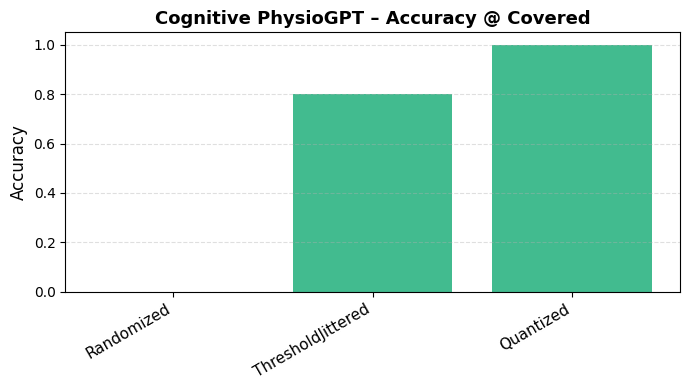

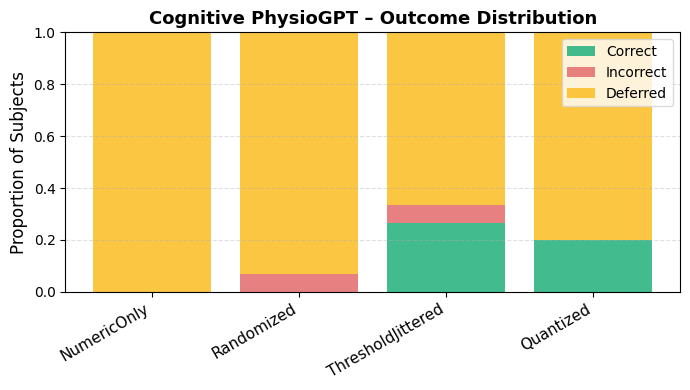

In [19]:
plot_physio_summary(summary_counts, title="Cognitive PhysioGPT", save_prefix="cognitive_physio")

# Modality Ablation

In [20]:
def summarize_eeg_subject_strength(eeg_df, fs=128, win_sec=2, alpha_thr=0.20, beta_thr=0.20):
    # 1) compute per-channel band ratios as you already do
    anomalies = eeg_band_anomaly_detector(eeg_df, sampling_rate=fs, window_sec=win_sec,
                                          alpha_thresh=alpha_thr, beta_thresh=beta_thr)
    # 2) extract ratios per channel (mean across windows)
    import re, numpy as np, pandas as pd
    ch_stats = {}

    # Collect latest ratio per channel from anomaly strings (fallback if ratios missing)
    for a in anomalies:
        m_ch = re.search(r"(EEG\.[A-Z0-9]+|[A-Z0-9]+)", a)
        m_ra = re.search(r"ratio\s*=\s*([\d.]+)", a)
        if m_ch and m_ra:
            ch = m_ch.group(0).replace("EEG.","")
            r  = float(m_ra.group(1))
            typ = "alpha" if "alpha" in a.lower() else ("beta" if "beta" in a.lower() else None)
            if typ:
                ch_stats.setdefault(ch, {}).setdefault(typ, []).append(r)

    # Aggregate
    rows = []
    for ch, d in ch_stats.items():
        alpha_mean = np.mean(d.get("alpha", [np.nan]))
        beta_mean  = np.mean(d.get("beta",  [np.nan]))
        rows.append({"ch": ch, "alpha_mean": alpha_mean, "beta_mean": beta_mean})
    agg = pd.DataFrame(rows) if rows else pd.DataFrame(columns=["ch","alpha_mean","beta_mean"])

    # Region map (simple)
    REGIONS = {
        "frontal":  ["AF3","AF4","F3","F4","F7","F8","FC5","FC6"],
        "temporal": ["T7","T8"],
        "parietal": ["P7","P8"],
        "occipital":["O1","O2"]
    }
    def region_of(ch):
        for k,v in REGIONS.items():
            if ch in v: return k
        return "other"

    agg["region"] = agg["ch"].map(region_of)
    n_ch = len(agg)

    # Counts/fractions
    n_alpha_low = int((agg["alpha_mean"] < alpha_thr).sum()) if n_ch else 0
    n_beta_low  = int((agg["beta_mean"]  < beta_thr ).sum()) if n_ch else 0
    frac_alpha_low = n_alpha_low / n_ch if n_ch else 0.0
    frac_beta_low  = n_beta_low  / n_ch if n_ch else 0.0

    # Region counts (alpha OR beta low)
    agg["any_low"] = (agg["alpha_mean"] < alpha_thr) | (agg["beta_mean"] < beta_thr)
    region_counts = agg.groupby("region")["any_low"].sum().to_dict()
    n_regions_affected = sum(1 for c in region_counts.values() if c >= 1)

    widespread = (n_alpha_low + n_beta_low >= 5) or (n_regions_affected >= 2)

    # Global medians (drop NaN)
    alpha_med = float(agg["alpha_mean"].median()) if n_ch else float("nan")
    beta_med  = float(agg["beta_mean"].median())  if n_ch else float("nan")

    # Build compact text
    summary = (
        f"EEG summary (subject-level):\n"
        f"- channels: {n_ch}\n"
        f"- alpha_low_frac(<{alpha_thr}): {frac_alpha_low:.2f} (n={n_alpha_low})\n"
        f"- beta_low_frac(<{beta_thr}): {frac_beta_low:.2f} (n={n_beta_low})\n"
        f"- regions_affected(>=1 low): {n_regions_affected}  {region_counts}\n"
        f"- alpha_median: {alpha_med:.2f} | beta_median: {beta_med:.2f}\n"
        f"- widespread_flag: {str(widespread)}"
    )
    return summary

In [21]:
import re
import numpy as np

def build_llm_prompt_with_ontology(eeg_anomalies, hrv_summary_text, subject_id="id"):
    """
    Full multimodal prompt: EEG + HRV together.
    """

    ontology_reference = """
Ontology Reference:
- Persistent increases in Theta and decreases in Alpha indicate possible Mild Cognitive Impairment (MCI).
- Suppressed Beta may reflect cognitive slowing.
- HRV suppression (SDNN < 30 ms) suggests reduced autonomic flexibility.
Integration Logic:
- Strong MCI evidence = EEG abnormal (alpha/beta suppression) + HRV suppressed.
- Mixed or borderline = partial EEG suppression or mild HRV changes → Needs review.
- Normal EEG and HRV = Healthy.
"""

    task_instruction = """
Task:
Using the EEG and HRV summaries, decide whether this subject shows signs of MCI.
Respond exactly in this format:

Conclusion: [Healthy / MCI / Needs clinical review]
Explanation: [Brief justification using both EEG and HRV findings]
"""

    # Clean EEG anomalies (keep 5–7 most relevant)
    eeg_text = "\n".join([a for a in eeg_anomalies if any(k in a.lower() for k in ["alpha","beta","theta"])][:7])

    if isinstance(hrv_summary_text, dict):
        hrv_text = hrv_summary_text.get("Summary", str(hrv_summary_text))
    else:
        hrv_text = str(hrv_summary_text)

    return f"Subject ID: {subject_id}\n{ontology_reference}\n\nEEG Summary:\n{eeg_text}\n\nHRV Summary:\n{hrv_text}\n\n{task_instruction}"


def prompt_eeg_only_v2(eeg_strength_text, subject_id="id"):
    ontology = """
Ontology (EEG-only triage):
- Strong impairment evidence: widespread alpha or beta suppression across ≥2 regions or ≥5 channels.
- Weak or isolated suppression may reflect normal variability.
- Normal pattern: balanced alpha/beta, <3 suppressed channels, ≤1 region affected.
"""
    task = """
Task:
Based only on the EEG summary, output exactly one label:
Conclusion: [Healthy / MCI / Needs clinical review]
Explanation: [Brief justification using counts/regions/widespread flag]
"""
    return f"Subject: {subject_id}\n{ontology}\n{eeg_strength_text}\n{task}"


def prompt_hrv_only(hrv_text, subject_id="id"):
    ontology = """
Ontology (HRV-only reasoning):
- SDNN < 30 ms = autonomic suppression often linked to cognitive decline or stress.
- 30 ≤ SDNN ≤ 50 ms = borderline; interpretation depends on context.
- SDNN > 50 ms = normal autonomic flexibility, typical of healthy subjects.
"""
    task = """
Task:
Based only on the HRV summary, output exactly one label:
Conclusion: [Healthy / MCI / Needs clinical review]
Explanation: [Brief justification referencing SDNN value and threshold interpretation]
"""
    return f"Subject: {subject_id}\n{ontology}\nHRV Summary:\n{hrv_text}\n{task}"

In [22]:
import pandas as pd
from tqdm import tqdm

def run_physioGPT_variant(TRUE_LABELS, variant="EEG+HRV"):
    """
    Runs PhysioGPT across subjects and stores detailed reasoning traces.
    Supported variants: "EEG+HRV", "EEG-only", "HRV-only".
    """
    results = []

    for subject_id, cond in tqdm(TRUE_LABELS.items(), desc=f"Running {variant}"):
        eeg_file = os.path.join(EEG_DIR, f"{subject_id}_with_timestamp.csv")
        hrv_file = os.path.join(HRV_DIR, f"{subject_id}_HRV_with_timestamp.csv")

        try:
            eeg_df, hrv_df = None, None
            eeg_anoms, hrv_summary = [], ""

            # --- Load EEG/HRV depending on variant ---
            if os.path.exists(eeg_file):
                eeg_df = pd.read_csv(eeg_file)
            if os.path.exists(hrv_file):
                hrv_df = pd.read_csv(hrv_file)

            # === VARIANT HANDLING ===
            if variant == "EEG+HRV":
                eeg_anoms = eeg_band_anomaly_detector(eeg_df)
                hrv_summary = detect_hrv_suppression(hrv_df)
                prompt = build_llm_prompt_with_ontology(eeg_anoms, hrv_summary)

            elif variant == "EEG-only":
                eeg_anoms = eeg_band_anomaly_detector(eeg_df)
                eeg_strength = summarize_eeg_subject_strength(eeg_df)
                prompt = prompt_eeg_only_v2(eeg_strength, subject_id)

            elif variant == "HRV-only":
                hrv_summary = detect_hrv_suppression(hrv_df)
                if isinstance(hrv_summary, dict):
                    hrv_text = hrv_summary["Summary"]
                else:
                    hrv_text = str(hrv_summary)
                prompt = prompt_hrv_only(hrv_text, subject_id)

            else:
                raise ValueError(f"Unknown variant: {variant}")

            # === Call the LLM ===
            llm_response = call_llm_api(prompt)
            response_text = str(llm_response)  # full text
            decision = parse_llm_output_flexible(response_text)

            # === Extract explanation ===
            import re
            match = re.search(r"Explanation:\s*(.*)", response_text, re.DOTALL | re.IGNORECASE)
            explanation = match.group(1).strip() if match else "No explanation parsed."

            # === Store result ===
            results.append({
                "Subject": subject_id,
                "True": "MCI" if cond == 1 else "Healthy",
                "Pred": decision,
                "Explanation": explanation,
                "Variant": variant,
                "Model": "gpt-4o"
            })

        except Exception as e:
            print(f"[Error] {subject_id}: {e}")
            results.append({
                "Subject": subject_id,
                "True": "MCI" if cond == 1 else "Healthy",
                "Pred": "error",
                "Explanation": str(e),
                "Variant": variant,
                "Model": "gpt-4o"
            })

    return pd.DataFrame(results)

In [23]:
df_eeg_results  = run_physioGPT_variant(TRUE_LABELS, "EEG-only")
df_hrv_results  = run_physioGPT_variant(TRUE_LABELS, "HRV-only")


Running HRV-only: 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]


In [24]:
df_eeg_results

,Subject,True,Pred,Explanation,Variant,Model
0,subject_0_394,Healthy,Healthy,Only 1 channel and 1 region affected with no w...,EEG-only,gpt-4o
1,subject_0_399,Healthy,Healthy,Only 1 channel and 1 region affected with no w...,EEG-only,gpt-4o
2,subject_0_462,Healthy,Healthy,Only 1 channel and 1 region affected with no w...,EEG-only,gpt-4o
3,subject_0_463,Healthy,Healthy,Only 1 channel and 1 region affected with no w...,EEG-only,gpt-4o
4,subject_0_468,Healthy,Healthy,Only 1 channel and 1 region affected with no w...,EEG-only,gpt-4o
5,subject_0_475,Healthy,Healthy,Only 1 channel and 1 region affected with no w...,EEG-only,gpt-4o
6,subject_0_476,Healthy,Healthy,Only 1 channel and 1 region affected with no w...,EEG-only,gpt-4o
7,subject_1_397,MCI,Healthy,Only 1 channel and 1 region affected with no w...,EEG-only,gpt-4o
8,subject_1_455,MCI,Healthy,Only 1 channel and 1 region affected with no w...,EEG-only,gpt-4o
9,subject_1_456,MCI,Healthy,Only 1 channel and 1 region affected with no w...,EEG-only,gpt-4o


In [25]:
df_hrv_results

,Subject,True,Pred,Explanation,Variant,Model
0,subject_0_394,Healthy,Healthy,The SDNN value of 60.74 ms indicates normal au...,HRV-only,gpt-4o
1,subject_0_399,Healthy,Healthy,The SDNN value of 54.35 ms is greater than 50 ...,HRV-only,gpt-4o
2,subject_0_462,Healthy,Healthy,The SDNN value of 70.78 ms is greater than 50 ...,HRV-only,gpt-4o
3,subject_0_463,Healthy,Review,"SDNN of 28.49 ms is below 30 ms, indicating au...",HRV-only,gpt-4o
4,subject_0_468,Healthy,Healthy,The SDNN value of 65.70 ms is greater than 50 ...,HRV-only,gpt-4o
5,subject_0_475,Healthy,Review,The SDNN value of 34.49 ms falls within the bo...,HRV-only,gpt-4o
6,subject_0_476,Healthy,Review,The SDNN value of 36.61 ms falls within the bo...,HRV-only,gpt-4o
7,subject_1_397,MCI,Review,The SDNN value of 41.39 ms falls within the bo...,HRV-only,gpt-4o
8,subject_1_455,MCI,Review,"SDNN = 23.77 ms, which is below 30 ms, indicat...",HRV-only,gpt-4o
9,subject_1_456,MCI,MCI,"The SDNN value of 20.55 ms is below 30 ms, ind...",HRV-only,gpt-4o


In [26]:
import pandas as pd
import numpy as np

def matthews_corrcoef_binary(y_true, y_pred):
    """Computes MCC for binary classification ignoring 'Review' deferrals."""
    mask = ~y_pred.str.lower().eq("review")
    y_true_f = y_true[mask]
    y_pred_f = y_pred[mask]

    if len(y_true_f) == 0:
        return np.nan

    TP = np.sum((y_true_f == "MCI") & (y_pred_f == "MCI"))
    TN = np.sum((y_true_f == "Healthy") & (y_pred_f == "Healthy"))
    FP = np.sum((y_true_f == "Healthy") & (y_pred_f == "MCI"))
    FN = np.sum((y_true_f == "MCI") & (y_pred_f == "Healthy"))

    denom = np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    return 0 if denom == 0 else (TP * TN - FP * FN) / denom


def summarize_physio_outcomes(df):
    """
    Summarizes PhysioGPT modality results into counts and performance metrics.
    Must include columns ['True', 'Pred', 'Variant'].
    """
    summaries = []

    for variant, dsub in df.groupby("Variant"):
        total = len(dsub)
        correct = np.sum(dsub["Pred"] == dsub["True"])
        deferred = np.sum(dsub["Pred"].str.lower() == "review")
        incorrect = total - correct - deferred

        coverage = (total - deferred) / total if total else np.nan
        acc_cov = correct / (total - deferred) if (total - deferred) > 0 else np.nan
        mcc = matthews_corrcoef_binary(dsub["True"], dsub["Pred"])

        summaries.append({
            "Variant": variant,
            "Total": total,
            "Correct": correct,
            "Incorrect": incorrect,
            "Deferred": deferred,
            "Coverage": round(coverage, 2),
            "Accuracy@Covered": round(acc_cov, 3) if not np.isnan(acc_cov) else "---",
            "MCC": round(mcc, 2) if not np.isnan(mcc) else "---"
        })

    return pd.DataFrame(summaries).set_index("Variant")

In [28]:
# Merge all into one DataFrame for easy summarization
df_all_variants = pd.concat([df_eeg_results, df_hrv_results])

# Generate summary counts
summary_modalities = summarize_physio_outcomes(df_all_variants)
display(summary_modalities)

,Total,Correct,Incorrect,Deferred,Coverage,Accuracy@Covered,MCC
Variant,,,,,,,
EEG-only,15,7,8,0,1.0,0.467,0.0
HRV-only,15,6,0,9,0.4,1.000,1.0


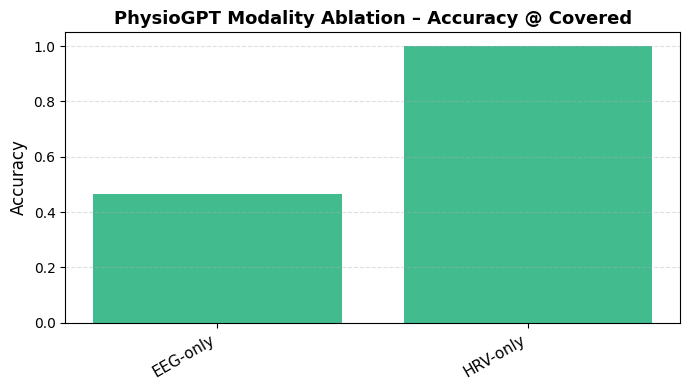

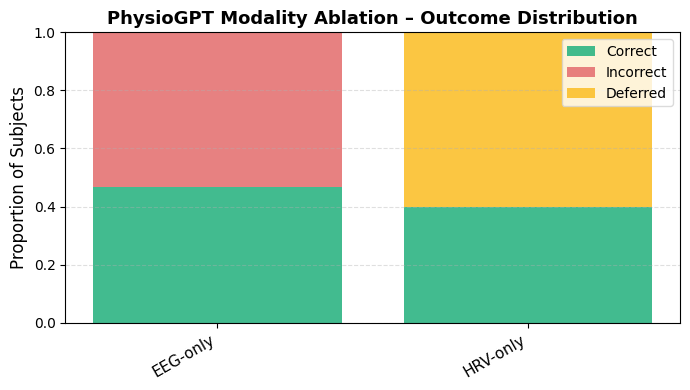

In [29]:
plot_physio_summary(summary_modalities, title="PhysioGPT Modality Ablation")

# Baselines (Summaries)

In [30]:
import re, os, numpy as np, pandas as pd
from tqdm import tqdm

def extract_numeric_features(eeg_df, hrv_df):
    """
    Build compact numeric summary features from EEG + HRV.
    Returns dict with numeric fields for ML baseline.
    """
    # --- EEG metrics ---
    eeg_summary = summarize_eeg_subject_strength(eeg_df)
    # Parse numeric fields from text summary
    def find_val(pattern, text):
        m = re.search(pattern, text)
        return float(m.group(1)) if m else np.nan

    feats = {
        "n_channels": find_val(r"channels:\s*(\d+)", eeg_summary),
        "alpha_low_frac": find_val(r"alpha_low_frac.*?:\s*([\d\.]+)", eeg_summary),
        "beta_low_frac": find_val(r"beta_low_frac.*?:\s*([\d\.]+)", eeg_summary),
        "regions_affected": find_val(r"regions_affected.*?:\s*(\d+)", eeg_summary),
        "alpha_median": find_val(r"alpha_median:\s*([\d\.]+)", eeg_summary),
        "beta_median": find_val(r"beta_median:\s*([\d\.]+)", eeg_summary),
        "widespread_flag": 1.0 if "widespread_flag: True" in eeg_summary else 0.0,
    }

    # --- HRV metrics ---
    hrv_result = detect_hrv_suppression(hrv_df)
    hrv_text = hrv_result["Summary"] if isinstance(hrv_result, dict) else str(hrv_result)
    feats["sdnn_ms"] = find_val(r"SDNN\s*=\s*([\d\.]+)", hrv_text)

    return feats

In [35]:
ML_features = []

for subject_id, cond in tqdm(TRUE_LABELS.items(), desc="Building ML features"):
    eeg_file = os.path.join(EEG_DIR, f"{subject_id}_with_timestamp.csv")
    hrv_file = os.path.join(HRV_DIR, f"{subject_id}_HRV_with_timestamp.csv")

    try:
        eeg_df = pd.read_csv(eeg_file)
        hrv_df = pd.read_csv(hrv_file)
        feats = extract_numeric_features(eeg_df, hrv_df)
        feats["Subject"] = subject_id
        feats["Label"] = cond  # 1=MCI, 0=Healthy
        ML_features.append(feats)
    except Exception as e:
        print(f"[Error] {subject_id}: {e}")

df_ml = pd.DataFrame(ML_features).fillna(0)
X = df_ml.drop(columns=["Subject", "Label"])
y = df_ml["Label"]

Building ML features: 100%|██████████| 15/15 [00:46<00:00,  3.11s/it]


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import pandas as pd

# --- 1️⃣ Split data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# --- 2️⃣ Models reproduced from Boudaya et al. (2024) ---
models = {
    "k-NN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "Naïve Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM (RBF)": SVC(kernel="rbf", probability=False, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(32, 16), max_iter=500, random_state=42)
}

# --- 3️⃣ Evaluate ---
rows = []
for name, clf in models.items():
    pipe = make_pipeline(StandardScaler(), clf)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    rec  = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1   = f1_score(y_test, y_pred, pos_label=1, zero_division=0)

    rows.append({
        "Model": name,
        "Accuracy": round(acc, 2),
        "Precision": round(prec, 2),
        "Recall": round(rec, 2),
        "F1": round(f1, 2)
    })

ml_baselines = pd.DataFrame(rows)
display(ml_baselines)

,Model,Accuracy,Precision,Recall,F1
0,k-NN (k=5),0.6,0.6,1.0,0.75
1,Naïve Bayes,0.6,0.6,1.0,0.75
2,Random Forest,0.6,0.6,1.0,0.75
3,SVM (RBF),0.6,0.6,1.0,0.75
4,MLP,0.6,0.6,1.0,0.75
